In [228]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html
import unicodedata
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sacha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [229]:
train_data = pd.read_csv('train.csv')

label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_data['labels'] = train_data[label_columns].apply(lambda x: list(x), axis=1)

train_data.drop(['id'], inplace=True, axis=1)
train_data.drop(label_columns, inplace=True, axis=1)

train_data.head()

,comment_text,labels
0,Explanation\r\nWhy the edits made under my use...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\r\nMore\r\nI can't make any real suggestions...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [230]:
# get rows where labels are all 0
zero_data = train_data[train_data['labels'].map(lambda d: sum(d)) == 0]
#drop rows where labels are all 0
train_data = train_data[train_data['labels'].map(lambda d: sum(d)) > 0]
# get 3000 random rows from zero_data
zero_data = zero_data.sample(n=len(train_data['labels']), random_state=1)
# concat zero_data with train_data
train_data = pd.concat([train_data, zero_data])
# shuffle rows
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,comment_text,labels
0,Edit-a-thon tomorrow (Saturday) in Oakland \r\...,"[0, 0, 0, 0, 0, 0]"
1,"""\r\nI know the elements articles are a PITA a...","[0, 0, 0, 0, 0, 0]"
2,"==So what do I do? Everyone supports him, I'm...","[0, 0, 0, 0, 0, 0]"
3,"I've been a Wikipedian since 22 July, 2006, an...","[1, 0, 1, 0, 1, 0]"
4,This article sucks.\r\n\r\nThis is precisely w...,"[1, 0, 1, 0, 0, 0]"


In [231]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def to_lowercase(text):
    return text.lower()


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train_data['comment_text'] = train_data['comment_text'].apply(lambda x: clean_text(x))

In [232]:
train_data.head()

,comment_text,labels
0,editathon tomorrow saturday oakland hi hope jo...,"[0, 0, 0, 0, 0, 0]"
1,know element article pita involve lot defense ...,"[0, 0, 0, 0, 0, 0]"
2,everyone support im try report,"[0, 0, 0, 0, 0, 0]"
3,ive wikipedian since july administrator since ...,"[1, 0, 1, 0, 1, 0]"
4,article suck precisely wikipedia kind thing ap...,"[1, 0, 1, 0, 0, 0]"


In [233]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20       # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(train_data['comment_text'])
test_portion=.025

sentences=list(train_data['comment_text'])
labels= list(train_data['labels'])

In [234]:
tokenizer = Tokenizer(num_words=1000, oov_token='UNK')
tokenizer.fit_on_texts(sentences)
# Extract binary BoW features
sequences = tokenizer.texts_to_sequences(sentences)
vocab_size = len(tokenizer.word_index) + 1
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

num_epochs = 10

training_padded = np.array(training_sequences)
testing_padded = np.array(test_sequences)
training_labels = np.array(training_labels)
testing_labels = np.array(test_labels)

In [235]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 20, input_length=max_length),
    Bidirectional(layers.GRU(64)),
    layers.Flatten(),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 20)            20000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              33024     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
Total params: 53,798
Trainable params: 53,798
Non-trainable params: 0
_________________________________________________________________


In [236]:
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    batch_size = 256,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
99/99 [==============================] - 7s 36ms/step - loss: 0.4181 - accuracy: 0.9362 - val_loss: 0.3138 - val_accuracy: 0.9720
Epoch 2/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2470 - accuracy: 0.9712 - val_loss: 0.2238 - val_accuracy: 0.9720
Epoch 3/10
99/99 [==============================] - 3s 26ms/step - loss: 0.2150 - accuracy: 0.9712 - val_loss: 0.2157 - val_accuracy: 0.9720
Epoch 4/10
99/99 [==============================] - 3s 26ms/step - loss: 0.2108 - accuracy: 0.9712 - val_loss: 0.2146 - val_accuracy: 0.9720
Epoch 5/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2092 - accuracy: 0.9711 - val_loss: 0.2150 - val_accuracy: 0.9720
Epoch 6/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2077 - accuracy: 0.9710 - val_loss: 0.2136 - val_accuracy: 0.9689
Epoch 7/10
99/99 [==============================] - 3s 27ms/step - loss: 0.2069 - accuracy: 0.9690 - val_loss: 0.2133 - val_accuracy: 0.9720
Epoch 8/10
99

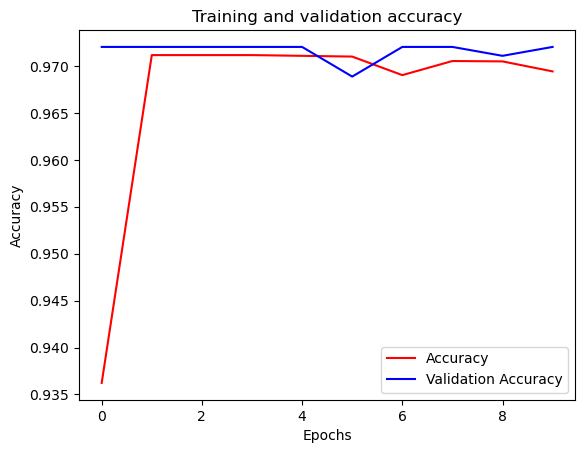

<Figure size 640x480 with 0 Axes>

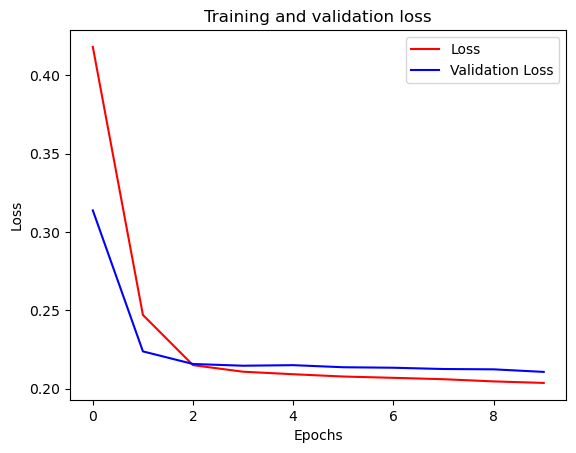

<Figure size 640x480 with 0 Axes>

In [237]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [238]:
# show f1 score
from sklearn.metrics import f1_score
predictions = model.predict(testing_padded)
print(f1_score(testing_labels, predictions.round(), average='macro'))

0.42038111113683896


In [239]:
# get 200 first words of the test set
test_data = pd.read_csv('test.csv').head(200)
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: clean_text(x))
test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [240]:
#plot 10 first predictions with expected labels
predictions = model.predict(test_padded)


In [252]:
i = ""
test = {'col1': [i]}
df = pd.DataFrame(data=test)
df['col1'] = df['col1'].apply(lambda x: clean_text(x))
test_sequences = tokenizer.texts_to_sequences(df['col1'])

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


predictions = model.predict(test_padded)
print(predictions)

[[0.9877149  0.13846195 0.5772294  0.05575287 0.6886521  0.24605486]]


In [242]:
model.save('GRU-padd.h5')